# Layer Combination and Favorability Modeling `geoPFA`: 2D Example from Newberry Volcano, OR
This notebook continues the `geoPFA` tutorial series using the **processed data** prepared in the previous notebook.  

Here, we load the preprocessed configuration and datasets, then use the *Voter–Veto* method to combine layers into geothermal favorability models.  

We’ll cover:
- Loading the processed PFA configuration  
- Reestablishing project paths, reference CRS, data extent, etc.
- Reading in supporting data for plotting and visualization

## 1. Imports and Setup

In [1]:
# --- General imports ---
from pathlib import Path
import geopandas as gpd

# --- geoPFA core classes ---
from geopfa.data_readers import GeospatialDataReaders
from geopfa.geopfa2d.processing import Cleaners  # TODO: change to geoPFA.processing
from geopfa.geopfa2d.plotters import GeospatialDataPlotters  # TODO: change to geoPFA.plotters
from geopfa.io.data_writers import GeospatialDataWriters
from geopfa.geopfa2d.layer_combination import VoterVeto

# --- Utilities ---
from rex.utilities.loggers import init_logger
from rex.utilities.utilities import safe_json_load

### Define Directories and CRS


In [2]:
# Target CRS (UTM Zone 10N for Newberry, Oregon)
target_crs = 26910

# Define key directories relative to this notebook
notebook_dir = Path(__file__).resolve().parent if "__file__" in locals() else Path.cwd()
project_dir = notebook_dir.parent

data_dir = project_dir / "data"
config_dir = project_dir / "config"

print("Notebook directory:", notebook_dir)
print("Data directory:", data_dir)
print("Config directory:", config_dir)

Notebook directory: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/2D/notebooks
Data directory: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/2D/data
Config directory: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/2D/config


### Load the Processed PFA Configuration

In [3]:
pfa_path = config_dir / "newberry_superhot_processed_config.json"
pfa = safe_json_load(str(pfa_path))  # Convert Path → str for safe_json_load
print(f"Loaded PFA configuration from: {pfa_path.name}")

Loaded PFA configuration from: newberry_superhot_processed_config.json


### Load Contextual Data for Plotting
Here we import a well path with associated temperature data for context in plots. `geoPFA` also allows the input of an area outline.

In [4]:
outline_path = data_dir / "supporting_data" / "national_monument_boundary" / "NNVM_bounds.shp"
outline = gpd.read_file(outline_path).to_crs(target_crs)

print(f"Loaded project outline: {outline_path.name}")


Loaded project outline: NNVM_bounds.shp


## 2. Reading Processed Data and Setting Extent

Now that we’ve loaded the processed configuration, we’ll read the **processed data layers** that were generated in the previous notebook.  
Each dataset corresponds to the `model` output created by functions such as `interpolate_points`.

This step ensures that every layer is loaded with consistent metadata (CRS, extent, units) before being combined.


### Gather Processed Data

In [5]:
pfa = GeospatialDataReaders.gather_processed_data(data_dir,pfa,crs=target_crs)

criteria: geologic
	 component: heat
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: temperature_model_500m
		 reading layer: earthquakes
	 component: reservoir
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: earthquakes
		 reading layer: lineaments
	 component: insulation
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: earthquakes
		 reading layer: temperature_model_500m


Each layer is placed back under
`pfa["criteria"][criteria]["components"][component]["layers"][layer]["model"]`,
exactly where the processing functions would have written it in the previous step.

#### Set Extent
To ensure proper alignment, we’ll re-establish the same 2D extent used during processing.
This guarantees that layer combination occurs on a consistent grid.

In [6]:
extent_layer = (
    pfa["criteria"]["geologic"]["components"]["heat"]["layers"]["mt_resistivity_joint_inv"]["model"]
)
extent = Cleaners.get_extent(extent_layer)

print(f"Extent: {extent}")

Extent: [624790.891073, 4825350.71118, 653145.891073, 4855310.71118]


The extent should match exactly what was defined in the previous notebook.
If layers were processed elsewhere or on a different grid, they must be re-projected or re-interpolated before combination.

## 3. Transformation and Layer Combination

With all data aligned, we can now combine layers into **component** and **criteria** favorability models using a modified version of the *Voter–Veto* method published in  [Ito et al., 2017](https://doi.org/10.1016/j.geothermics.2016.11.004).

The method:
- Normalizes each layer and transforms into marginal favorability layers for each component
- Weights and combines marginal favorability layers to form component favorabiltiy (e.g., heat, reservoir, insulation)
- Weights and combines components into a higher-level criteria models (e.g., geologic favorability)
- Optionally normalizes outputs to a defined scale (e.g., 0–5)
- Weights and combines criteria favorability models into an overall combined favorability model (not included in this example)

The figure below provides context for where we are in the full `geoPFA` framework:
![pfa](figs/pfa_transform_combine.png)

In [7]:
pfa = VoterVeto.do_voter_veto(
    pfa,
    normalize_method="minmax",  # normalize each layer between its min & max
    component_veto=False,       # no veto at the component level
    criteria_veto=True,         # apply veto across components if needed
    normalize=True,             # normalize final favorability model
    norm_to=5,                  # scale favorability to 0-5
)

print("Layer combination complete using the Voter-Veto method.")

Combining 2D PFA layers with the voter-veto method. 
criterion: geologic
    component: heat
        layer: density_joint_inv
        - Transformed with method: negate
        - Normalized with method: minmax
        layer: mt_resistivity_joint_inv
        - Transformed with method: negate
        - Normalized with method: minmax
        layer: temperature_model_500m
        - Transformed with method: None
        - Normalized with method: minmax
        layer: earthquakes
        - Transformed with method: negate
        - Normalized with method: minmax
    component: reservoir
        layer: density_joint_inv
        - Transformed with method: negate
        - Normalized with method: minmax
        layer: mt_resistivity_joint_inv
        - Transformed with method: negate
        - Normalized with method: minmax
        layer: earthquakes
        - Transformed with method: none
        - Normalized with method: minmax
        layer: lineaments
        - Transformed with method: none
 

## 4. Visualizing Favorability Results

With the *Voter–Veto* layer combination complete, we can now visualize the resulting
favorability models.

Each output is stored under:
- `pfa["criteria"][criteria]["components"][component]["pr_norm"]` - normalized **component** favorability  
- `pfa["criteria"][criteria]["pr_norm"]` - normalized **criteria**-level (overall) favorability  

We’ll plot both the total (geologic) favorability model and the individual component models
to interpret how heat, reservoir, and insulation contribute to the overall result.


### Combined Geologic Favorability

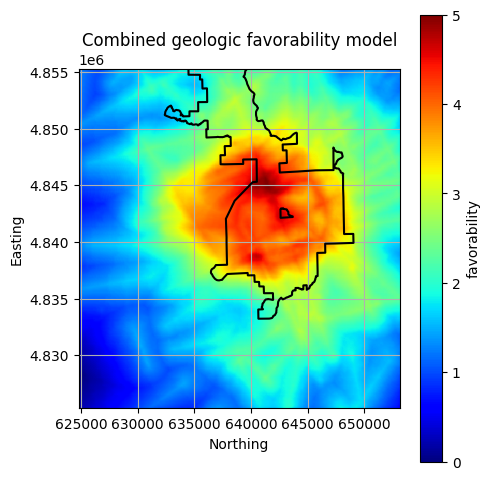

In [8]:
# Combined (criteria-level) favorability model
gdf = pfa["criteria"]["geologic"]["pr_norm"].copy()

col = "favorability"
units = "favorability"
title = "Combined geologic favorability model"

GeospatialDataPlotters.geo_plot(
    gdf,
    col,
    units,
    title,
    area_outline=outline,
    extent=extent,
    figsize=(5, 5),
    markersize=0.75
)

### Component Favorability Maps

Plot individual component favorability layers to compare how each contributes to the total.

geologic
	heat


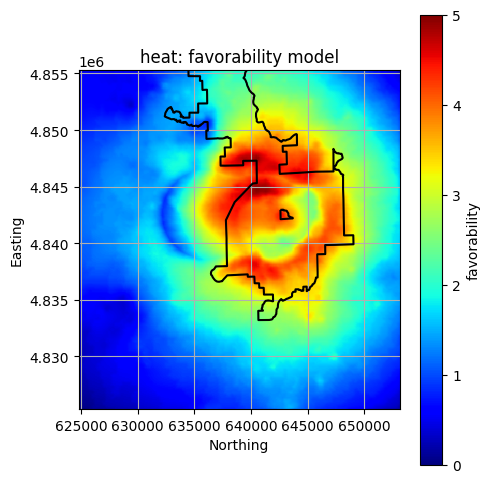

	reservoir


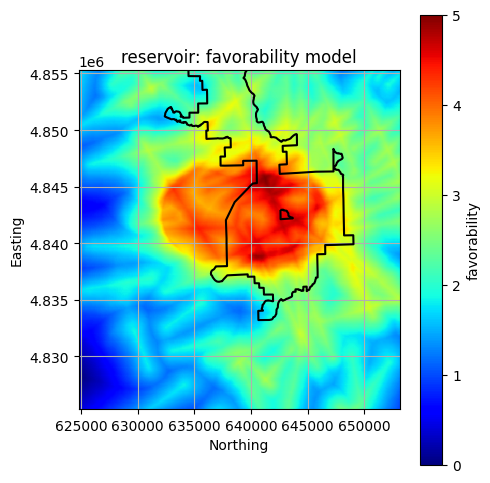

	insulation


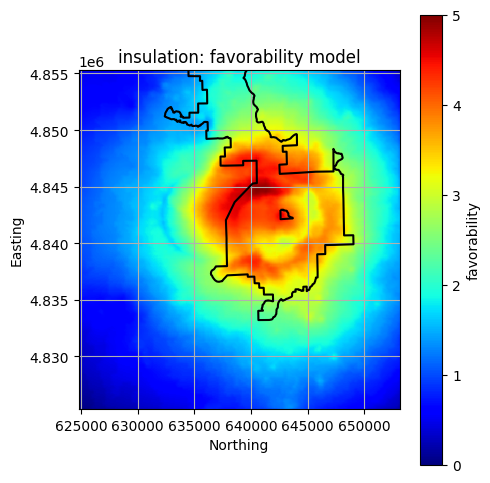

In [9]:
for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")

        gdf = comp_data["pr_norm"].copy()
        col = "favorability"
        units = "favorability"
        title = f"{component}: favorability model"

        GeospatialDataPlotters.geo_plot(
            gdf,
            col,
            units,
            title,
            area_outline=outline,
            extent=extent,
            figsize=(5, 5),
            markersize=0.75,
        )

## 5. Exporting Favorability Maps

The final step is to export the combined and component‐level favorability models as shapefiles.  
These outputs can be opened directly in **QGIS**, **ArcGIS**, or other geospatial tools for visualization and further analysis.

Each GeoDataFrame is written to a shapefile using `GeospatialDataWriters.write_shapefile()`,  
which preserves geometry, attributes, and the project CRS.

### Combined Favorability Map

In [10]:
output_dir = project_dir / "outputs"
output_dir.mkdir(exist_ok=True)

# Combined (overall) favorability
gdf = pfa["pr_norm"]
out_fp = output_dir / "combined_favorability_map_no_exclusions_highT.shp"

GeospatialDataWriters.write_shapefile(gdf, out_fp, target_crs)
print(f"Combined favorability map written to: {out_fp}")

/Users/ntaverna/Documents/DEEPEN/geoPFA/geopfa/io/data_writers.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_crs(target_crs).to_file(path)
/usr/local/anaconda3/envs/geopfa-new/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'favorability' to 'favorabili'
  ogr_write(


Combined favorability map written to: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/2D/outputs/combined_favorability_map_no_exclusions_highT.shp


## Criteria- and Component-Level Maps

Export each criteria map (e.g., geologic) and its components (heat, reservoir, insulation).


In [11]:
for criteria, crit_data in pfa["criteria"].items():
    print(criteria)

    # Criteria-level export
    crit_out_dir = output_dir / f"{criteria}_criteria_favorability_maps"
    crit_out_dir.mkdir(exist_ok=True)

    gdf = crit_data["pr_norm"]
    crit_fp = crit_out_dir / f"{criteria}_criteria_favorability_map.shp"
    GeospatialDataWriters.write_shapefile(gdf, crit_fp, target_crs)
    print(f"\tWrote {criteria} criteria map")

    # Component-level exports
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")
        comp_out_dir = output_dir / f"{component}_component_favorability_maps"
        comp_out_dir.mkdir(exist_ok=True)

        gdf = comp_data["pr_norm"]
        comp_fp = comp_out_dir / f"{component}_component_favorability_map.shp"
        GeospatialDataWriters.write_shapefile(gdf, comp_fp, target_crs)
        print(f"\t\tWrote {component} component map")

geologic


/Users/ntaverna/Documents/DEEPEN/geoPFA/geopfa/io/data_writers.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_crs(target_crs).to_file(path)
/usr/local/anaconda3/envs/geopfa-new/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'favorability' to 'favorabili'
  ogr_write(


	Wrote geologic criteria map
	heat


/Users/ntaverna/Documents/DEEPEN/geoPFA/geopfa/io/data_writers.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_crs(target_crs).to_file(path)
/usr/local/anaconda3/envs/geopfa-new/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'favorability' to 'favorabili'
  ogr_write(


		Wrote heat component map
	reservoir


/Users/ntaverna/Documents/DEEPEN/geoPFA/geopfa/io/data_writers.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_crs(target_crs).to_file(path)
/usr/local/anaconda3/envs/geopfa-new/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'favorability' to 'favorabili'
  ogr_write(


		Wrote reservoir component map
	insulation


/Users/ntaverna/Documents/DEEPEN/geoPFA/geopfa/io/data_writers.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_crs(target_crs).to_file(path)
/usr/local/anaconda3/envs/geopfa-new/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'favorability' to 'favorabili'
  ogr_write(


		Wrote insulation component map


### Summary

You now have:
- A combined **geologic criteria favorability map**
- Individual **component favorability models**   

The resulting models can be exported as shapefiles or CSV files to be used for:
- Overlaying favorability with site infrastructure or exclusion zones  
- Cross-checking results against geologic models  
- Sharing results externally in standard GIS formats  

This concludes the example workflow for **import → data processing → layer combination → export**  
using `geoPFA` for the Newberry Volcano play fairway analysis.